In [1]:
#!pip install tensorflow==2.14

import tensorflow as tf
import numpy as np
import os
import random
import pandas as pd
#import seaborn as sns
from datetime import datetime
import matplotlib.pyplot as plt

tfk = tf.keras
tfkl = tf.keras.layers
print(tf.__version__)

# Random seed for reproducibility
seed = 42

random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

from tensorflow.keras.layers import Input, LSTM, Bidirectional, Embedding, RepeatVector, Dense, Dot, Activation, Concatenate, Flatten,Conv1D, MaxPooling1D
from tensorflow.keras.layers import GlobalAveragePooling1D, BatchNormalization, Dropout, Bidirectional,  MultiHeadAttention, LayerNormalization

from statsmodels.tsa.stattools import pacf, acf
from sklearn.preprocessing import RobustScaler




2.13.0


In [2]:
def remove_padding(series, valid_period):
    start, end = valid_period
    return series[start:end]

def encode_categories(categories):
    # Integer encoding of categorical data (letters)
    unique_categories = np.unique(categories)
    category_to_int = {category: i for i, category in enumerate(unique_categories)}
    return np.array([category_to_int[category] for category in categories])

In [3]:
X = np.load('/kaggle/input/training/training_data.npy')
valid_periods = np.load('/kaggle/input/training/valid_periods.npy')
categories = np.load('/kaggle/input/training/categories.npy')
categories=encode_categories(categories)

start_times=valid_periods[:,0]
end_times=valid_periods[:,1]

trimmed_data = [remove_padding(X[i], valid_periods[i]) for i in range(len(X))]


In [4]:
# Thresholds for identifying low and high scales
low_threshold = 0.05
high_threshold = 0.95


# Initialize lists to store low and high scale information
low_centers = []
high_centers = []

low_scales = []
high_scales = []

# Row-wise Robust Scaling
Xpredscaled=np.zeros_like(X)
scalespred = np.zeros(X.shape[0], dtype=float)
centerspred = np.zeros(X.shape[0], dtype=float)

for i in range(X.shape[0]):

    # Extract each row as a column vector
    row_data = X[i, :].reshape(-1, 1)

    nonzero_mask = X[i, :] != 0

    # Extract non-zero values and reshape to a column vector
    row_data_nonzero = X[i, nonzero_mask].reshape(-1, 1)

    # Fit the scaler to the non-zero values
    scaler = RobustScaler().fit(row_data_nonzero)

    # Apply scaling and flatten the result to the corresponding indices
    Xpredscaled[i, nonzero_mask] = scaler.transform(row_data_nonzero).flatten()

    # Store scale and center for later use
    scalespred[i] = scaler.scale_[0]
    centerspred[i] = scaler.center_[0]

    # Categorize scales and store corresponding information
    if scalespred[i] < low_threshold:
        low_scales.append(i)

    if scalespred[i] > high_threshold:
        high_scales.append(i)

    if centerspred[i] > high_threshold:
        high_centers.append(i)

    if centerspred[i] < low_threshold:
        low_centers.append(i)

# Convert lists to numpy arrays if needed
low_scales = np.array(low_scales)
high_scales = np.array(high_scales)

# Convert lists to numpy arrays if needed
low_centers = np.array(low_centers)
high_centers = np.array(high_centers)

# Union of scales
all_scales = np.union1d(low_scales, high_scales)

# Union of centers
all_centers = np.union1d(low_centers, high_centers)

all_indexes = np.union1d(all_scales, all_centers)

len(all_indexes)


print(len(all_scales), len(all_centers), len(all_indexes))


361 319 524


IndexError: index 377 is out of bounds for axis 0 with size 361

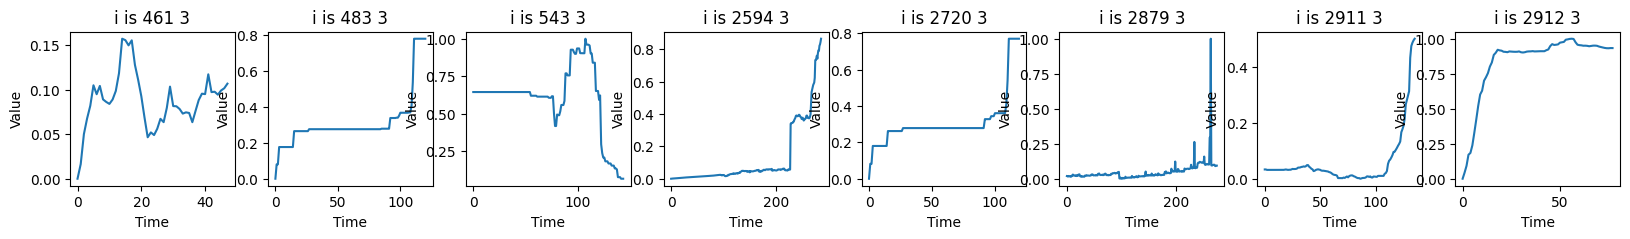

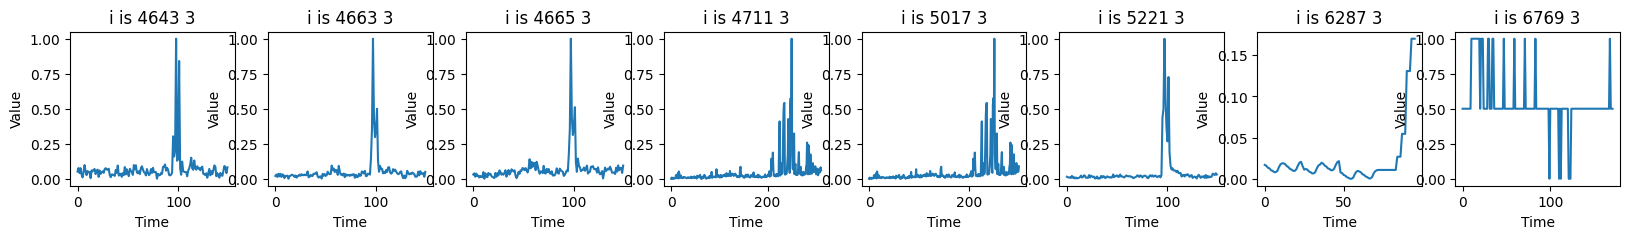

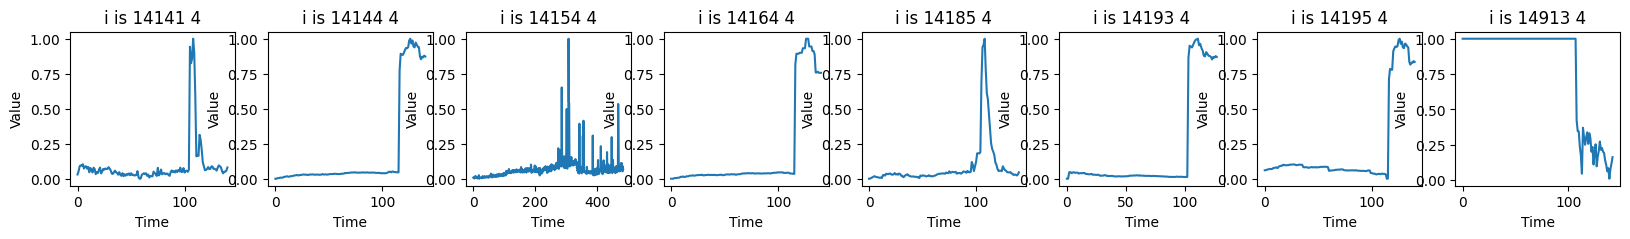

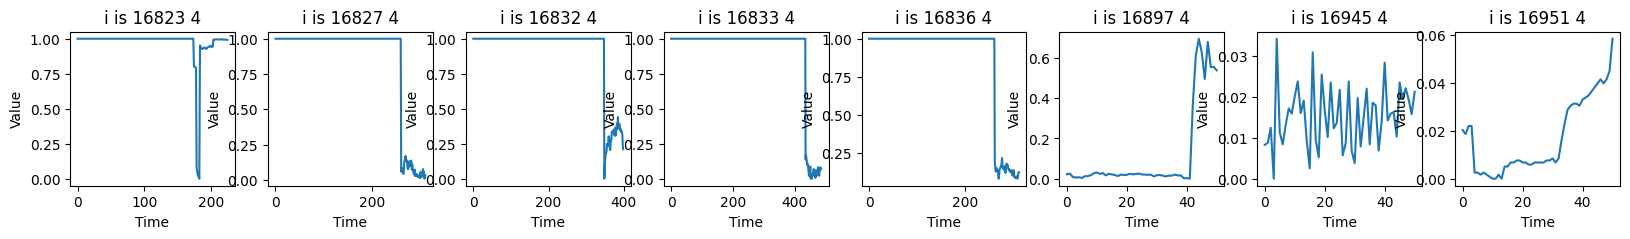

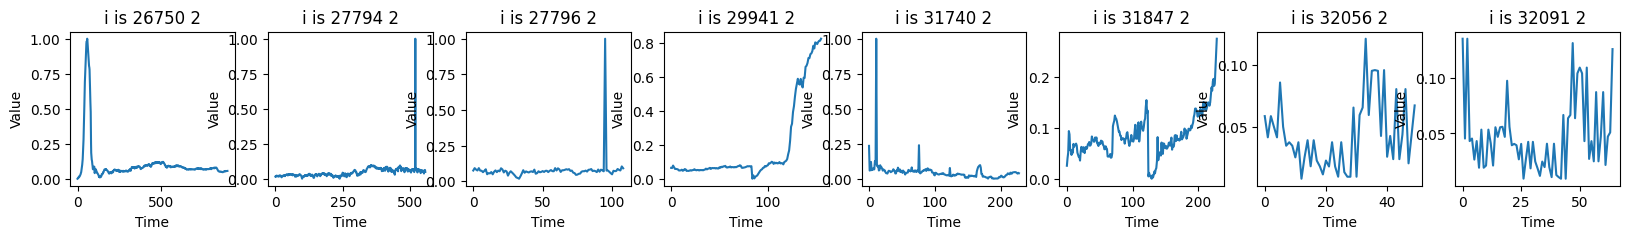

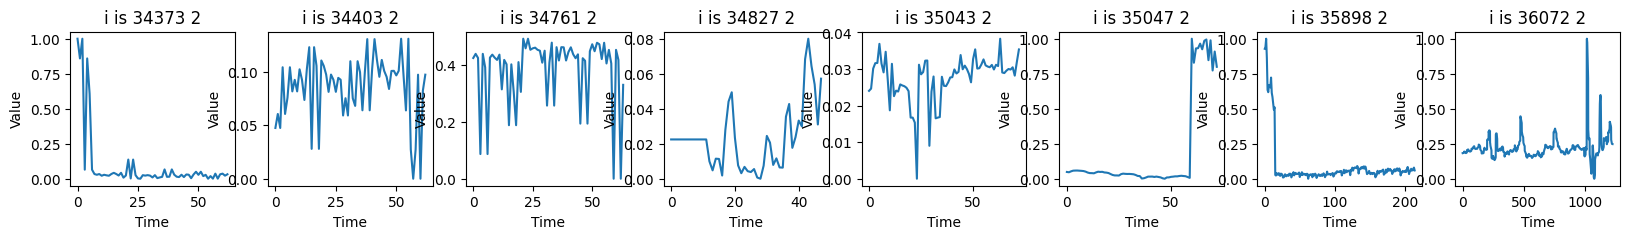

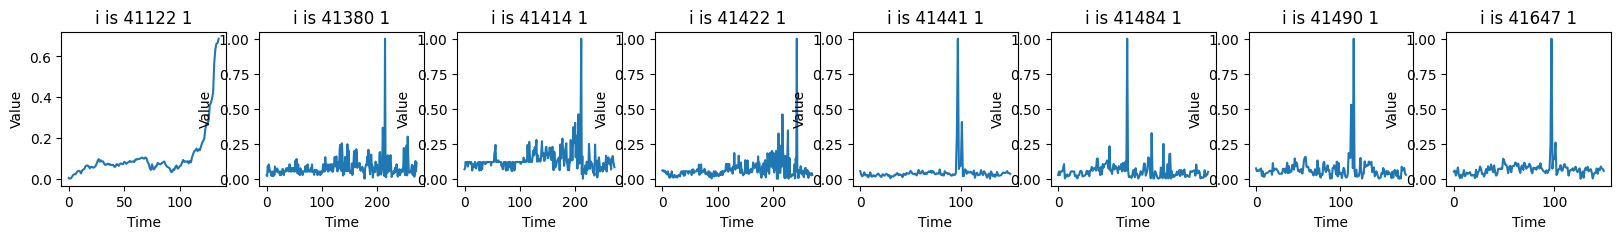

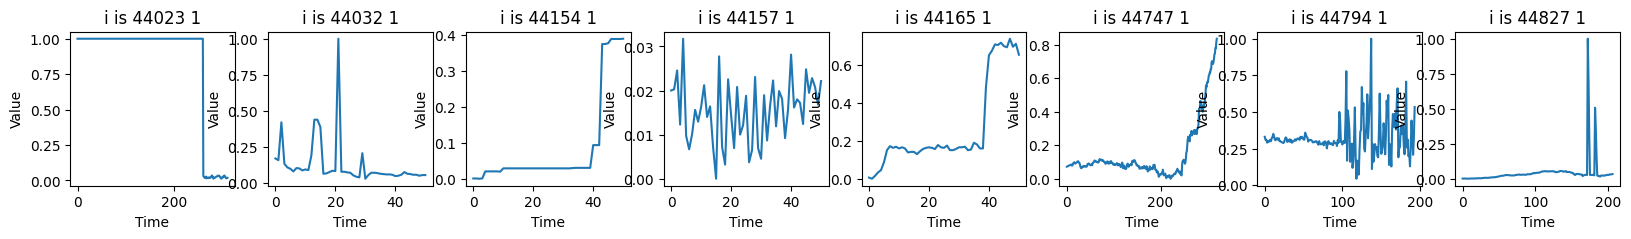

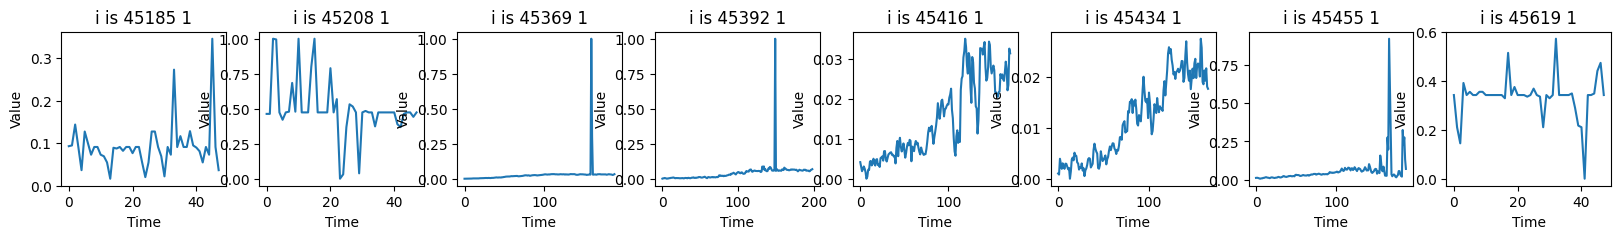

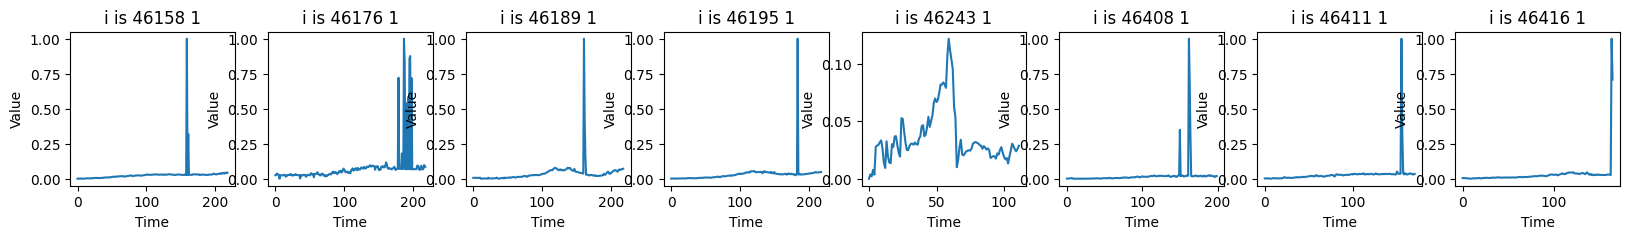

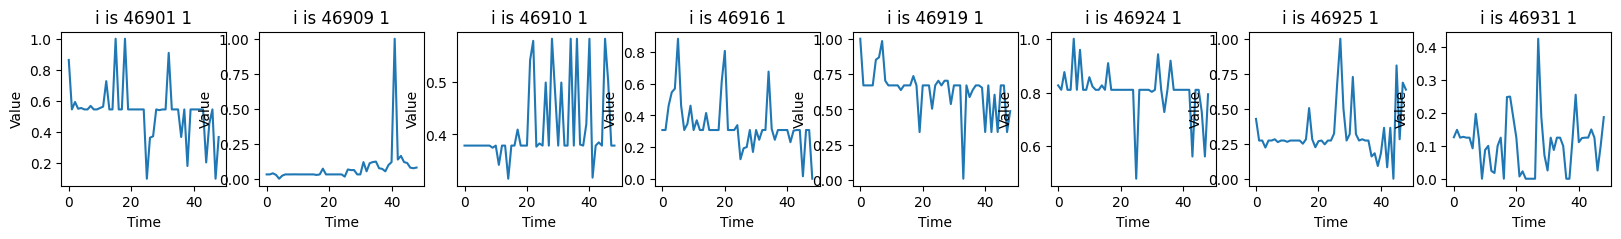

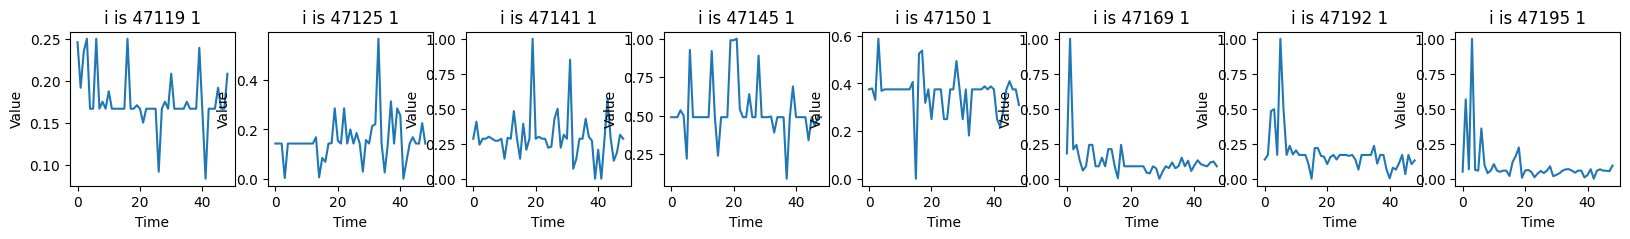

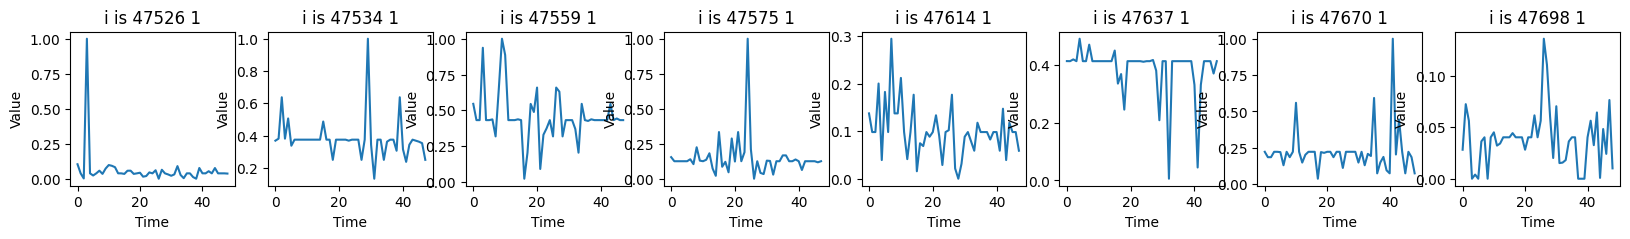

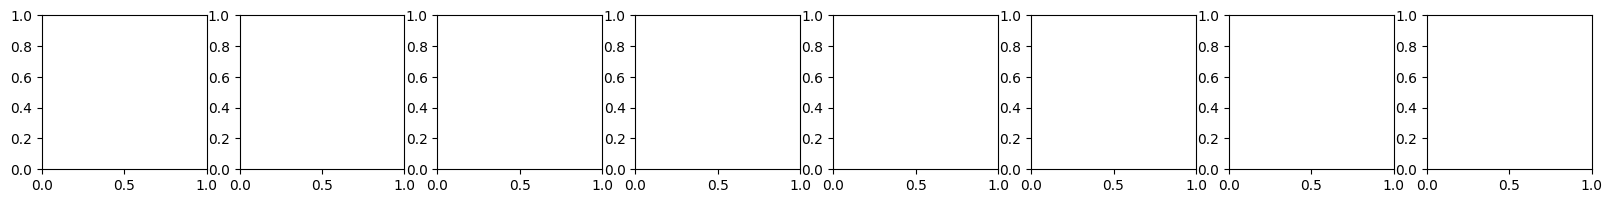

In [6]:
# Create a figure and axis for the subplots
N_rows=29
N_cols=8

for i in range (0, N_rows):
    fig, axes = plt.subplots(1,N_cols, figsize=(20,2))
    for j in range(N_cols):
        index=i*N_rows+j
        axes[j].plot(X[all_scales[index], start_times[all_scales[index]]: end_times[all_scales[index]]])
        axes[j].set_title(f'i is {all_scales[index]} {categories[all_scales[index]]}')
        axes[j].set_xlabel('Time')
        axes[j].set_ylabel('Value')

In [7]:
#First, we remove these outliers

X_noout = np.delete(X, all_scales, axis=0)
valid_periods_noout = np.delete(valid_periods, all_scales, axis=0)
categories_noout = np.delete(categories, all_scales, axis=0)
start_times_noout=valid_periods_noout[:,0]
end_times_noout=valid_periods_noout[:,1]

trimmed_data_noout = [row for i, row in enumerate(trimmed_data) if i not in all_scales]
print(len(trimmed_data_noout))

47639


In [8]:
#Find data too  SHORT, to exclude
lengths = [len(series) for series in trimmed_data_noout]

indexes_too_short=np.where(np.array(lengths)<=72)[0]
print(indexes_too_short)

indexes_too_long=np.where(np.array(lengths)>=1100)[0]
print(indexes_too_long)

indexes = np.insert(indexes_too_long,0,indexes_too_short)
indexes=indexes_too_short
print(len(indexes))

[    3   105   108 ... 47500 47542 47620]
[  121   210  2566  2569  2571 16979 17021 17026 17031 17032 17033 26593
 27828 32755 35386 35888 35891 35899 35932 35934 36852 37091 43590]
12763


In [9]:
X_noout2 = np.delete(X_noout, indexes, axis=0)
valid_periods_noout2 = np.delete(valid_periods_noout, indexes, axis=0)
categories_noout2 = np.delete(categories_noout, indexes, axis=0)
start_times_noout2=valid_periods_noout2[:,0]
end_times_noout2=valid_periods_noout2[:,1]

trimmed_data_noout2 = [row for i, row in enumerate(trimmed_data_noout) if i not in indexes]

print(X_noout.shape, len(categories_noout),len(start_times_noout),len(end_times_noout) )
print(len(trimmed_data_noout))

(47639, 2776) 47639 47639 47639
47639


In [10]:
print(X_noout2.shape,valid_periods_noout2.shape, categories_noout2.shape)

(34876, 2776) (34876, 2) (34876,)


In [11]:

def build_sequences(array, window, stride, start_times, end_times, categories, shuffle=True, seed=42, telescope=18):
    df = []
    y = []
    cat=[]

    category_flags = encode_categories(categories)  # Integer-encode the category flags

    for idx in range(len(array)):
        start_time = start_times[idx]
        end_time = end_times[idx]
        category_flag = category_flags[idx]  # Extract the integer-encoded category flag

        # Extract the actual non-zero part of the time series within the specified time range
        actual_data = array[idx, start_time:end_time]

        padding_check = len(actual_data)%window

        if(padding_check != 0):
            # Compute padding length
            padding_len = window - len(actual_data)%window
            padding = np.zeros(padding_len,dtype='float32')
            actual_data = np.concatenate((padding,actual_data))
            assert len(actual_data) % window == 0

        # Genera sequenze con la finestra e lo stride specificati
        for i in range(0, len(actual_data) - window - telescope, stride):

            sequence = actual_data[i:i + window]

            df.append(sequence)

            y.append(actual_data[i+window: i+ window+telescope])
            cat.append(categories[idx])

    df = np.array(df)
    y = np.array(y)
    cat=np.array(cat)
    cat=encode_categories(cat)

    return df, y, cat

In [12]:
from sklearn.model_selection import StratifiedShuffleSplit
seed = 42

myX=X_noout2
mycategories=categories_noout2
my_start_times=start_times_noout2
my_end_times=end_times_noout2

# Define the StratifiedShuffleSplit
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.1, random_state=seed)

train_indexes=[]
val_indexes=[]

#We only use the categories in the stratified split

# Perform the split
for train_index, val_index in sss.split(myX, mycategories):

    train_indexes.append(train_index)
    val_indexes.append(val_index)

    X_train_noseq, X_val_noseq = myX[train_index], myX[val_index]
    cat_train_noseq, cat_val_noseq = mycategories[train_index], mycategories[val_index]
    start_times_train_noseq, start_times_val_noseq = my_start_times[train_index], my_start_times[val_index]
    end_times_train_noseq, end_times_val_noseq = my_end_times[train_index], my_end_times[val_index]

# Check the shapes of the resulting sets
print("X_train_noseq shape:", X_train_noseq.shape)
print("X_val_noseq shape:", X_val_noseq.shape)
print("cat_train_noseq shape:", cat_train_noseq.shape)
print("cat_val_noseq shape:", cat_val_noseq.shape)
print("start_times_train_noseq shape:", start_times_train_noseq.shape)
print("end_times_train_noseq shape:", end_times_train_noseq.shape)

X_train_noseq shape: (31388, 2776)
X_val_noseq shape: (3488, 2776)
cat_train_noseq shape: (31388,)
cat_val_noseq shape: (3488,)
start_times_train_noseq shape: (31388,)
end_times_train_noseq shape: (31388,)


In [13]:
window_size=200
stride_size=6

X_train, y_train, cats = build_sequences(X_train_noseq,
                                   window=window_size,
                                   stride=stride_size,
                                   start_times=start_times_train_noseq,
                                   end_times=end_times_train_noseq,
                                   categories=cat_train_noseq)

X_val, y_val, cats_val = build_sequences(X_val_noseq,
                                   window=window_size,
                                   stride=stride_size,
                                   start_times=start_times_val_noseq,
                                   end_times=end_times_val_noseq,
                                   categories=cat_val_noseq)

print(X_train.shape, y_train.shape, cats.shape)
print( X_val.shape, y_val.shape, cats_val.shape)

(756069, 200) (756069, 18) (756069,)
(84571, 200) (84571, 18) (84571,)


In [ ]:
class data_augmentation(tf.keras.layers.Layer):
    def _init_(self, jitter_factor=0.01, **kwargs):
        super()._init_(**kwargs)
        self.jitter_factor = jitter_factor


    def call(self, inputs, training=None):
        if training:
            inputs = inputs.numpy()
            
            nottomask=np.where(inputs!=0.)

            # Add jitter by adding random noise ONLY to the nonzero positions.  
            jitter = np.random.normal(loc=0, scale=self.jitter_factor, size=len(nottomask))
            inputs[nottomask] += jitter

        return inputs


In [17]:
# Define the Time2Vec Layer
class Time2Vec(tf.keras.layers.Layer):
    def __init__(self, kernel_size=1):
        super(Time2Vec, self).__init__(trainable=True, name='Time2VecLayer')
        self.k = kernel_size

    def build(self, input_shape):
        # Determine feature dimension from the last dimension of the input shape
        feature_dim = input_shape[-1]
        if feature_dim is None:
            raise ValueError("The feature dimension of the input must be defined.")

        # Initialize weights
        self.wb = self.add_weight(name='wb', shape=(feature_dim,), initializer='uniform', trainable=True)
        self.bb = self.add_weight(name='bb', shape=(feature_dim,), initializer='uniform', trainable=True)
        # Adjust the shape of wa and ba to match the kernel size
        self.wa = self.add_weight(name='wa', shape=(feature_dim, self.k), initializer='uniform', trainable=True)
        self.ba = self.add_weight(name='ba', shape=(self.k,), initializer='uniform', trainable=True)

    def call(self, x):
        # Linear part
        linear = self.wb * x + self.bb

        # Broadcasting to match the dimensions
        # The shapes of wa and x are made compatible for batch matrix multiplication
        sin_trans = tf.math.sin(tf.linalg.matmul(x, self.wa) + self.ba)

        # Concatenate linear and sin_trans along the last dimension
        return tf.concat([linear, sin_trans], axis=-1)

    
# Modify the LSTM model to include Time2Vec
def build_lstm_seq2seq_attention_t2v(input_shape, n_units, time2vec_dim,N_values_to_predict=18):
    input_layer = tfkl.Input(shape=input_shape, name='Input')
    category_input = tfkl.Input(shape=(1,), name='Category_Input')  # Assuming a single numeric category
    
    masked_input = tfkl.Masking(mask_value=0.0)(input_layer)

    # Time2Vec integration
    time_embedding = Time2Vec(time2vec_dim)(input_layer)

    encoder_x, encoder_h, encoder_c = tfkl.LSTM(units=n_units, return_sequences=True, return_state=True)(time_embedding)
    decoder_in = tfkl.RepeatVector(1)(encoder_h)
    x = tfkl.LSTM(units=n_units, return_sequences=True, return_state=False)(decoder_in, initial_state=[encoder_h, encoder_c])
    decoder_x = tfkl.Bidirectional(tfkl.LSTM(units=int(n_units/2), return_sequences=True, return_state=False))(x)

    attention = tfkl.Dot(axes=[2,2])([decoder_x, encoder_x])
    attention = tfkl.Activation('softmax')(attention)
    context = tfkl.Dot(axes=[2,1])([attention, encoder_x])

    concatenated_c = tfkl.Concatenate()([context, decoder_x])
    concatenated_c = tfkl.Flatten()(concatenated_c)
    output_layer = tfkl.Dense(N_values_to_predict)(concatenated_c)  # Number of telescope values

    model = tf.keras.Model(inputs=input_layer, outputs=output_layer, name='model')

    return model

input_shape = (200,1)
time2vec_dim = 3
n_units = 64
model = build_lstm_seq2seq_attention_t2v(input_shape,n_units,time2vec_dim,)
model.summary()
model.compile(loss=tfk.losses.MeanSquaredError(), optimizer=tfk.optimizers.Adam(1e-3), metrics=['mae'])

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 Input (InputLayer)          [(None, 200, 1)]             0         []                            
                                                                                                  
 Time2VecLayer (Time2Vec)    (None, 200, 4)               8         ['Input[0][0]']               
                                                                                                  
 lstm (LSTM)                 [(None, 200, 64),            17664     ['Time2VecLayer[0][0]']       
                              (None, 64),                                                         
                              (None, 64)]                                                         
                                                                                              

In [18]:
epochs=100
batch_size=256
history = model.fit(
    X_train,
    y_train,
    validation_data=(X_val, y_val),
    epochs = epochs,
    batch_size = batch_size,
    callbacks = [
        tfk.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=20, restore_best_weights=True),
        tfk.callbacks.ReduceLROnPlateau(monitor='val_loss', mode='min', patience=10, factor=0.5, min_lr=1e-5)
    ]
).history

Epoch 1/100
2954/2954 [==============================] - 61s 17ms/step - loss: 0.0153 - mae: 0.0830 - val_loss: 0.0116 - val_mae: 0.0719 - lr: 0.0010
Epoch 2/100
2954/2954 [==============================] - 48s 16ms/step - loss: 0.0108 - mae: 0.0701 - val_loss: 0.0109 - val_mae: 0.0697 - lr: 0.0010
Epoch 3/100
2954/2954 [==============================] - 48s 16ms/step - loss: 0.0103 - mae: 0.0678 - val_loss: 0.0104 - val_mae: 0.0668 - lr: 0.0010
Epoch 4/100
2954/2954 [==============================] - 48s 16ms/step - loss: 0.0095 - mae: 0.0644 - val_loss: 0.0096 - val_mae: 0.0637 - lr: 0.0010
Epoch 5/100
2954/2954 [==============================] - 48s 16ms/step - loss: 0.0091 - mae: 0.0629 - val_loss: 0.0095 - val_mae: 0.0632 - lr: 0.0010
Epoch 6/100
2954/2954 [==============================] - 48s 16ms/step - loss: 0.0090 - mae: 0.0622 - val_loss: 0.0093 - val_mae: 0.0624 - lr: 0.0010
Epoch 7/100
2954/2954 [==============================] - 48s 16ms/step - loss: 0.0088 - mae: 0.0615 

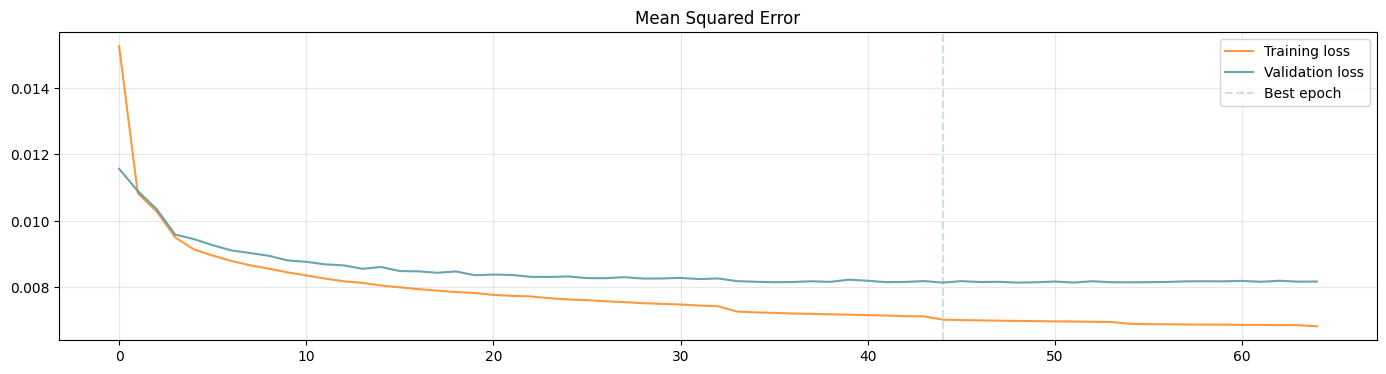

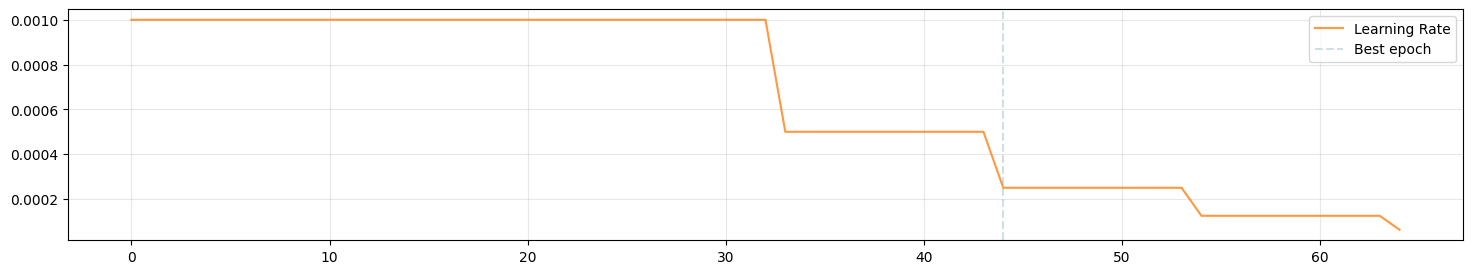

In [19]:
best_epoch = np.argmin(history['val_loss'])
plt.figure(figsize=(17,4))
plt.plot(history['loss'], label='Training loss', alpha=.8, color='#ff7f0e')
plt.plot(history['val_loss'], label='Validation loss', alpha=.9, color='#5a9aa5')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.title('Mean Squared Error')
plt.legend()
plt.grid(alpha=.3)
plt.show()

plt.figure(figsize=(18,3))
plt.plot(history['lr'], label='Learning Rate', alpha=.8, color='#ff7f0e')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.legend()
plt.grid(alpha=.3)
plt.show()

In [20]:
import shutil

model.save('SubmissionModel')
shutil.make_archive('SubmissionModel', 'zip', 'SubmissionModel')


'/kaggle/working/SubmissionModel.zip'